# Approach 2: K-means Clustering

Here, we use a K-means approach to cluster groups of pixels based on similarity. After performing edge detection on relevant clusters (red and blue channels extracted from an RGB format image) to count cells and calculate infection ratios for individual cells.

Steps include: 
1. Read image in as RGB
    - Split into color channels
2. Threshold red and blue channels to exclude background noise
    - Mask images based on thresholded color channels
3. Perform K-means clustering on thresholded image
4. Subset mask to include only red and blue clusters**
5. Perform Canny edge detection on the subsetted foreground
7. Use contours to classify cell infection 
    - Filter countours by area to find cells
    - Iterate through cells and calculate infection ratio
    - Report total cells and provide a table for individual cell infection ratios


In [1]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
import random

# Set seed for K-means clustering reproducibility
random.seed(10)

Text(0.5, 1.0, 'Thresholded Image')

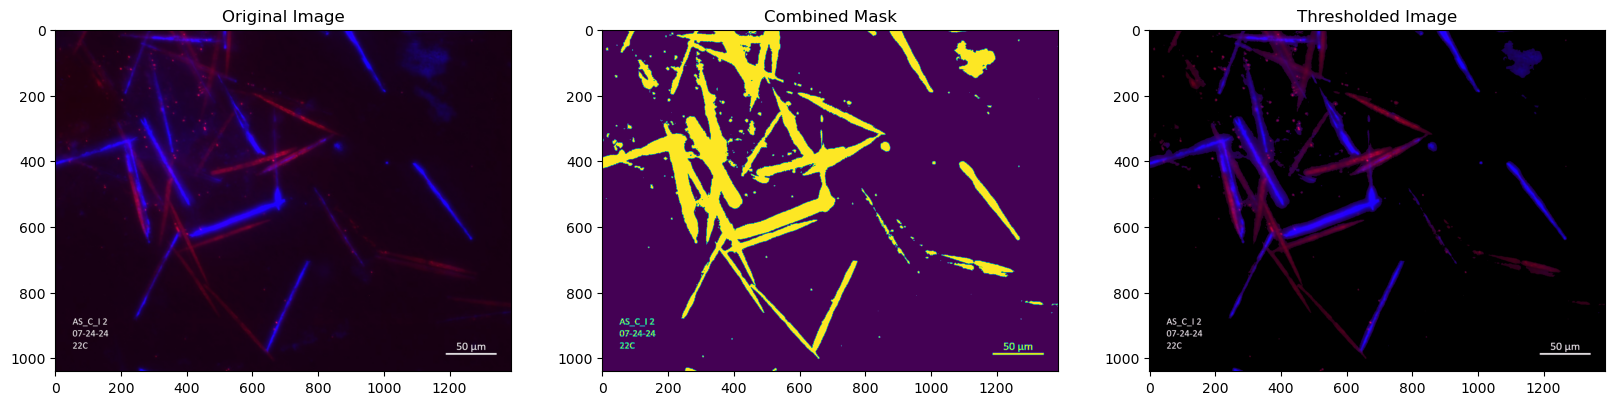

In [30]:
# 1. Read image and convert to RGB
# image_path = "../images/ClumpyLate_AS_C_I_22_2_20240724.jpg"  # WD path
image_path = "../data/images/ClumpyLate_AS_C_I_22_2_20240724.jpg"  # GH path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Split into RGB channels for thresholding
red_channel = image_rgb[:, :, 0]
blue_channel = image_rgb[:, :, 2]

# 2. Define thresholds for red and blue channels based on percentiles
red_threshold = np.percentile(red_channel, 92)
blue_threshold = np.percentile(blue_channel, 92)

    # Create binary masks for each color channel
_, red_mask = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
_, blue_mask = cv2.threshold(blue_channel, blue_threshold, 255, cv2.THRESH_BINARY)

    # Combine the red and blue masks
combined_mask = cv2.bitwise_or(red_mask, blue_mask)

    # Apply the mask to isolate high-intensity pixels in the image
thresholded_image = cv2.bitwise_and(image_rgb, image_rgb, mask=combined_mask)

    # Display the original and segmented images
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(combined_mask)
plt.title('Combined Mask')
plt.subplot(1, 3, 3)
plt.imshow(thresholded_image)
plt.title('Thresholded Image')


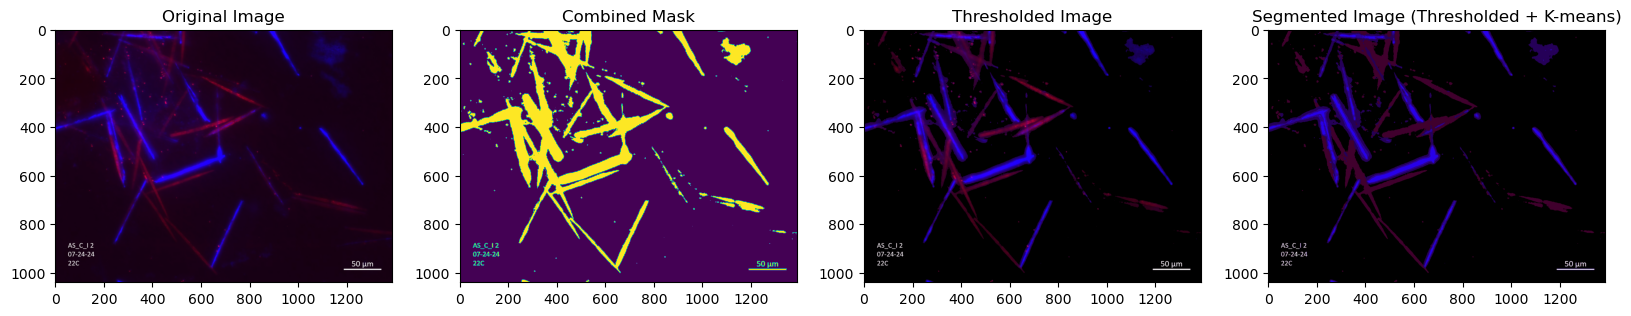

In [31]:
# 3. Perform K-means clustering
    # Flatten the masked pixels (ignore dark background)
masked_pixels = thresholded_image[combined_mask > 0]
pixels = masked_pixels.reshape((-1, 3)).astype(np.float32)

    # Define K-means criteria and number of clusters
k = 5  # Number of clusters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    # Perform K-means clustering
_, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert centers to uint8 for display
centers = np.uint8(centers)
    # Reconstruct segmented data using labels
segmented_data = centers[labels.flatten()]
    # Create an empty array to store the full-sized segmented image
segmented_image = np.zeros_like(image_rgb)
    # Fill in only the high-intensity pixels in the original mask
segmented_image[combined_mask > 0] = segmented_data

    # Display results
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(combined_mask)
plt.title('Combined Mask')
plt.subplot(1, 4, 3)
plt.imshow(thresholded_image)
plt.title('Thresholded Image')
plt.subplot(1, 4, 4)
plt.imshow(segmented_image)
plt.title('Segmented Image (Thresholded + K-means)')
plt.show()

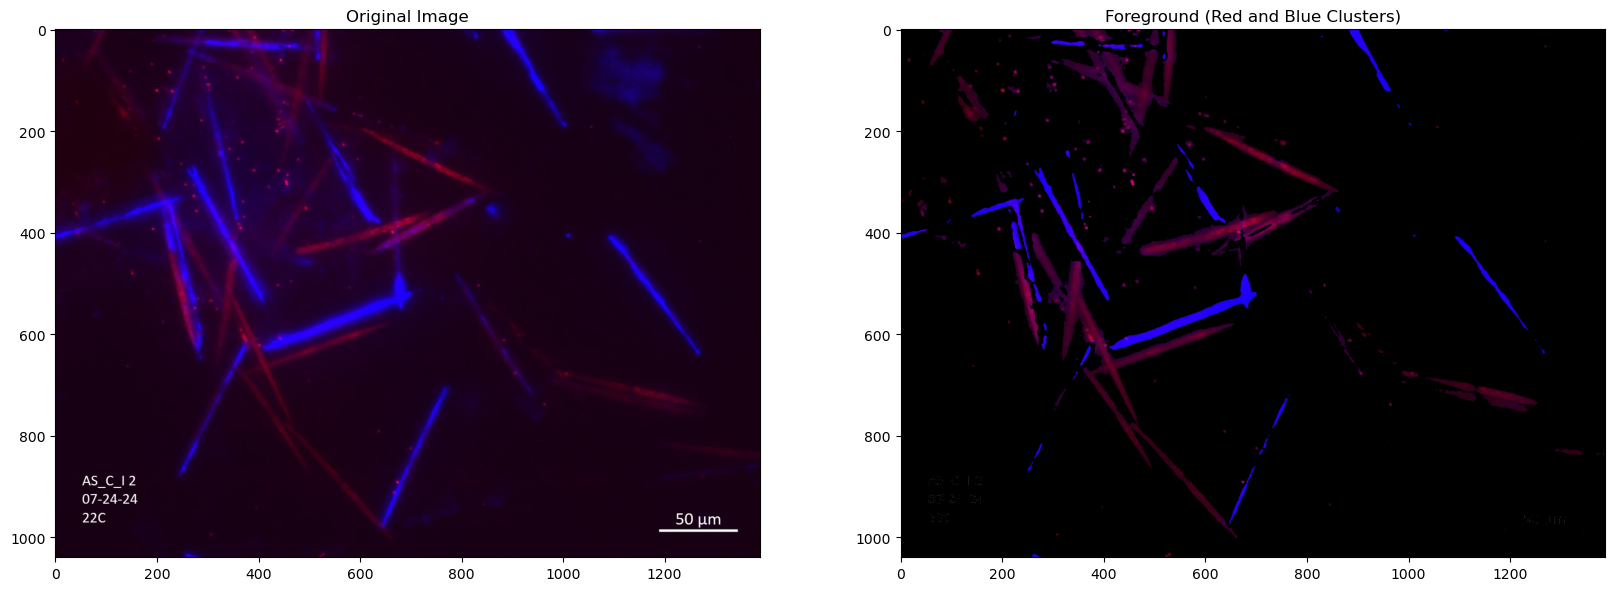

In [40]:
# 4. Subset mask by keeping only the clusters corresponding to red and blue
    # Define clusters for red and blue
        # cluster correlations: 0=words/bg; 1=red; 2=words/bg; 3=blue outline; 4=blue
        # cluster correlations: 0=words; 1=blue outline?; 2=red; 3=blue; 4=bg?
        # HOW DO I AUTOMATE THE CLUSTER SELECTION?
red_cluster = 1  # red
blue_cluster = 4  # Update based on actual cluster indices for blue

    # Reshape labels to match combined_mask shape
labels_reshaped = np.zeros(combined_mask.shape, dtype=int)
labels_reshaped[combined_mask > 0] = labels.flatten()

    # Create a mask that includes only the red and blue clusters
foreground_mask = np.isin(labels_reshaped, [red_cluster, blue_cluster])
    # Initialize the foreground image with black background
foreground_final = np.zeros_like(image_rgb)
    # Apply the mask to keep only the red and blue clusters
foreground_final[foreground_mask] = image_rgb[foreground_mask]

    # Display clusters
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(foreground_final)
plt.title('Foreground (Red and Blue Clusters)')
plt.show()


In [ ]:
# 5. Perform Canny edge detection on the final foreground
edges = cv2.Canny(foreground_final, 100, 200, apertureSize=3, L2gradient=False)

Total cells detected: 33

Individual Cell Blue:Red Ratios
    Cell Number  Red Intensity Sum  Blue Intensity Sum  Blue:Red Ratio
0             1              25603              152453        5.954498
1             2              12205               85595        7.013109
2             3              32053               19122        0.596574
3             4               9379               10715        1.142446
4             5              93114               66609        0.715349
5             6              12073               64218        5.319142
6             7               8343               36927        4.426106
7             8               5823                2935        0.504036
8             9              39419               29416        0.746239
9            10              10029               14851        1.480806
10           11              13912               64311        4.622700
11           12             216690             1401283        6.466764
12           13    

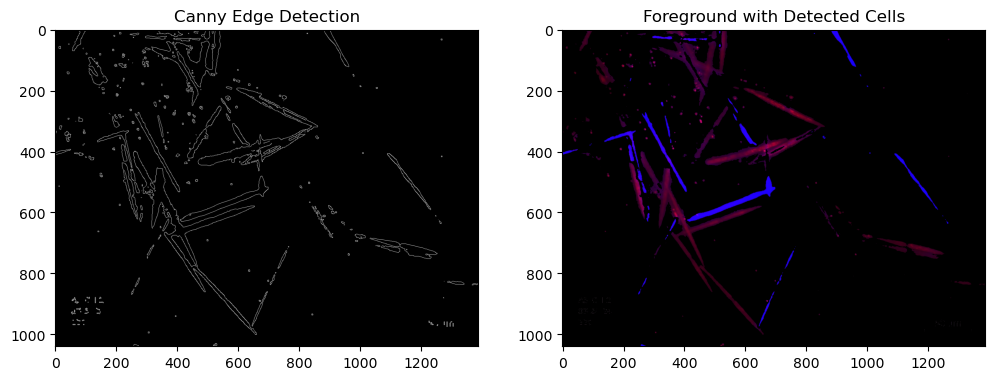

In [42]:
# 6. Find contours and filter by area
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Set minimum cell area threshold
min_area = 100
cell_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Initialize metrics for counting and blue:red ratio
total_cells = len(cell_contours)
cell_ratios = []

    # Count all filtered edges (cells) & calculate blue:red ratio
print(f"Total cells detected: {total_cells}")

    # Calculate blue:red ratios within each cell
for i, contour in enumerate(cell_contours):
    # Create a mask for each cell
    cell_mask = np.zeros(foreground_mask.shape, dtype=np.uint8)
    cv2.drawContours(cell_mask, [contour], -1, 255, -1)  # Fill contour to create mask

    # Extract pixels in red and blue channels for this cell
    red_values = red_channel[cell_mask == 255]
    blue_values = blue_channel[cell_mask == 255]

    # Calculate blue:red ratio for this cell
    red_sum = np.sum(red_values)
    blue_sum = np.sum(blue_values)
    blue_red_ratio = blue_sum / red_sum if red_sum > 0 else 0  # Avoid division by zero
    cell_ratios.append({
        'Cell Number': i + 1,
        'Red Intensity Sum': red_sum,
        'Blue Intensity Sum': blue_sum,
        'Blue:Red Ratio': blue_red_ratio
    })

    # Convert ratios to DataFrame for easy viewing
cell_ratios_df = pd.DataFrame(cell_ratios)

    # Calculate & report image overall blue:red ratio
total_red = np.sum(red_channel[foreground_mask])
total_blue = np.sum(blue_channel[foreground_mask])
overall_blue_red_ratio = total_blue / total_red if total_red > 0 else 0

    # Display results
print("\nIndividual Cell Blue:Red Ratios")
print(cell_ratios_df)
print(f"\nTotal Cells: {total_cells}")
print(f"Overall Blue:Red Ratio in Image: {overall_blue_red_ratio:.2f}")

    # Display the final cell edges
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.subplot(1, 2, 2)
plt.imshow(foreground_final)
plt.title('Foreground with Detected Cells')
plt.show()
